In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import datetime
import time
import sys
import os
import tables

pd.set_option('display.max_columns', None)

In [3]:
# !pip install tables
# !pip install bs4

# Load custom modules

These are downloaded to the Github repo from the MSD website. 
The original code was written in python 2, so some minor updates are needed to ensure they run in python 3.
To load the dataset, we need to clone the repo and add the directory that the python source files are saved in to your system path so that they can be imported. 

In [4]:
# Check current working directory
cur_dir = os.getcwd()
print("current dir:", cur_dir)

current dir: /Users/gena/Documents/GitHub/CS109B_MSD/notebooks/EDA


In [5]:
# Add MSD source code to your sys path so that the imports will work
# Change to wherever the github repo is cloned and point to the folder with the python source code from the repo 'PythronSrc'
sys.path.append(cur_dir + '/../../MSongsDB_code/PythonSrc/')

# Use the code saved in github rather than the original from the labROSA website
# The report version has edits to switch from python 2 to python 3 (more may be needed if we use other modules)
import hdf5_getters as GETTERS
import hdf5_utils as HDF5

need pg module and MBrainzDB folder of Python source code if you
want to use musicbrainz related functions, e.g. fill_hdf5_from_musicbrainz


# Load all of the subset data

First, we have to ave the uncompressed subset locally. Subset data is available here: http://static.echonest.com/millionsongsubset_full.tar.gz

This part of the notebook loads all of the data in the subset files to a dataframe.

In [17]:
# Path to the Million Song Dataset subset (uncompressed) - change to the location on your laptop
# Cannot store this on github as it is too large
msd_subset_path = '../../../MSD_data/MillionSongSubset/'

# Keep these - folders match the structure of the uncompressed file
msd_subset_data_path = os.path.join(msd_subset_path, 'data')
msd_subset_addf_path = os.path.join(msd_subset_path, 'AdditionalFiles')

In [18]:
# # Load previously saved file
# subset_full = pd.read_pickle(msd_subset_path+'subset_full.pkl')

In [19]:
# Find the HDF5 files
msd_dir = msd_subset_data_path+'/*/*/*/*.h5'
files = glob.glob(msd_dir)
print('Found {} files'.format(len(files)))

Found 10000 files


In [9]:
# List of getters for song metadata
getters = list(filter(lambda x: x[:4] == 'get_',HDF5.__dict__.keys()))

# Remove special case
getters.remove('get_num_songs') 

This loop loads the data from the HDF5 format into a pandas dataframe

In [9]:
# Get all data and load into a dataframe
def get_hdf5_data():
    ''' Pulls all of the HDF5 fields into a pandas dataframe '''
    subset_full = pd.DataFrame()
    song_data = {}
    print('Reading data...')
    for f in files:
        # Open file
        h5 = tables.open_file(f, mode = 'r')

        # Retrieve each feature
        for getter in getters:
            item = GETTERS.__getattribute__(getter)(h5)
            
            # Reformatting
            try:
                # Remove b'' for arrays of text due to old python 2 bytes format
                item = item.decode('utf-8')
            except:
                # Numeric data
                pass
            
            # Special case
            if getter == 'get_artist_terms':
                item = item.astype('U')
                
            song_data[getter] = item

        # Close each file
        h5.close()

        # Append to dataframe
        subset_full = subset_full.append(song_data, ignore_index = True)
        
    # Rename columns
    col_names = []
    for i in list(subset_full):
        # remove 'get_'
        temp = i[4:]
        col_names.append(temp)
    subset_full.columns = col_names
    
    print('Complete')
    return subset_full

In [10]:
# Get everything from HDF5 files
# Be patient, takes a while
subset_full = get_hdf5_data()

Reading data...
Complete


In [11]:
# Check shape is correct
subset_full.shape

(10000, 54)

There is a lot of data, and some of it is quite complex. Various fields contain multiple references, e.g. artist_mbid, artist_terms, bars_start. 

In [12]:
subset_full.head()

,analysis_sample_rate,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_mbid,artist_mbtags,artist_mbtags_count,artist_name,artist_playmeid,artist_terms,artist_terms_freq,artist_terms_weight,audio_md5,bars_confidence,bars_start,beats_confidence,beats_start,danceability,duration,end_of_fade_in,energy,key,key_confidence,loudness,mode,mode_confidence,release,release_7digitalid,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,segments_pitches,segments_start,segments_timbre,similar_artists,song_hotttnesss,song_id,start_of_fade_out,tatums_confidence,tatums_start,tempo,time_signature,time_signature_confidence,title,track_7digitalid,track_id,year
0,22050.0,16971.0,0.557460,0.386152,AREJXK41187B9A4ACC,46.71067,France,1.71819,c43bb0d6-94d7-410f-80fb-e5a243b18d23,[],[],Raphaël,2676.0,"[chanson, visual kei, hip hop, pop rock, briti...","[0.9106976156829982, 0.892165696549715, 1.0, 0...","[1.0, 0.9915376816967095, 0.9554596873428609, ...",d8bafd4a65d1855aec08991c8b013dc1,"[0.179, 0.373, 0.127, 0.015, 0.012, 0.119, 0.0...","[0.52458, 2.4444, 4.3658, 6.30006, 8.22086, 10...","[0.886, 0.725, 0.748, 0.721, 0.784, 0.417, 0.4...","[0.04257, 0.52458, 1.00659, 1.48632, 1.96605, ...",0.0,148.74077,0.192,0.0,0.0,0.591,-9.636,1.0,0.556,Je Sais Que La Terre Est Plate (Deluxe),275907.0,"[1.0, 1.0, 0.508, 0.334, 0.113, 0.593]","[0.0, 7.74174, 40.30707, 80.4797, 89.656, 127....","[0.0, 0.732, 1.0, 0.556, 1.0, 0.584, 0.559, 1....","[-60.0, -52.849, -42.59, -41.542, -32.881, -34...","[0.0, 0.19543, 0.02958, 0.0238, 0.02788, 0.020...","[-60.0, -60.0, -55.39, -46.295, -48.97, -39.43...","[[0.726, 0.112, 0.02, 0.019, 0.01, 0.038, 0.03...","[0.0, 0.19188, 0.60499, 0.84939, 1.10018, 1.36...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[b'ARVEJ9M1187FB4DC44', b'ARYDHN21187FB466A8',...",0.547953,SOGSMXL12A81C23D88,141.607,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.04257, 0.28357, 0.52458, 0.76558, 1.00659, ...",124.059,4.0,0.372,Je Sais Que La Terre Est Plate,3073568.0,TRARRZU128F4253CA2,2008.0
1,22050.0,92108.0,0.626958,0.434860,AR2XRFQ1187FB417FE,NaN,,NaN,a69cd724-2f57-4ed0-bfed-ba20401eb84c,[],[],Julie Zenatti,5772.0,"[chanson, dance pop, pop rock, soft rock, fema...","[1.0, 0.8729706020462483, 0.9823877698159625, ...","[1.0, 0.9211512994427619, 0.9124620665627354, ...",55f60c97280172e9276723c06e531996,"[0.716, 0.306, 0.015, 0.572, 0.529, 0.353, 0.2...","[8.69527, 12.01758, 14.81363, 20.09003, 22.693...","[0.773, 0.247, 0.402, 0.115, 0.092, 0.436, 0.5...","[0.59161, 1.33555, 2.07949, 2.82093, 3.56238, ...",0.0,252.99546,0.514,0.0,1.0,0.429,-11.061,0.0,0.670,Comme Vous,382807.0,"[1.0, 0.502, 0.721, 0.552, 0.575, 0.704, 0.332...","[0.0, 7.08047, 39.03442, 89.26989, 114.94898, ...","[0.0, 1.0, 0.276, 0.54, 0.009, 0.53, 0.624, 0....","[-59.854, -31.966, -33.722, -34.887, -36.92, -...","[0.46727, 0.08541, 0.0262, 0.05198, 0.05883, 0...","[-60.0, -59.869, -37.121, -39.899, -38.511, -3...","[[0.943, 1.0, 0.91, 0.782, 0.726, 0.806, 0.314...","[0.0, 0.51379, 0.89138, 1.30912, 1.65297, 2.05...","[[0.008, 170.986, 9.126, -28.685, 57.183, -50....","[b'ARAGSU61187B98C95C', b'ARO9XCZ1187B99C255',...",0.475638,SOMBCOW12AAF3B229F,241.424,"[0.365, 0.321, 0.29, 0.264, 0.238, 0.217, 0.20...","[0.59161, 0.84042, 1.08799, 1.33555, 1.58436, ...",80.084,4.0,0.533,On Efface,4249244.0,TRARRJL128F92DED0E,2004.0
2,22050.0,1701.0,0.425724,0.000000,ARODOO01187FB44F4A,NaN,,NaN,60bd8a1c-c093-4849-8f28-08101ca059b1,[],[],The Baltimore Consort,20540.0,"[early music, celtic, mediaeval, folk, christm...","[1.0, 1.0, 0.6760874700254027, 0.8857812190979...","[1.0, 0.9394607822094231, 0.7622625756944362, ...",053fb50807248bef996e6c7a5fe93533,"[0.014, 0.025, 0.049, 0.029, 0.11, 0.484, 0.35...","[1.95344, 6.35701, 10.70579, 15.07913, 19.4832...","[0.506, 0.467, 0.45, 0.682, 0.341, 0.406, 0.38...","[1.95344, 3.0622, 4.16548, 5.26467

I scraped the explanation of the fields from the website below. 

In [14]:
# Dataset file reference - scrape this from the labrosa website
import bs4 as bs
import requests

def get_reference_table(print_status = False):
    ''' Scrape the reference table for field names '''
    # Use cached version of the site since the main site is currently down
    target_url = 'https://webcache.googleusercontent.com/search?q=cache:D5jClkFvR94J:https://labrosa.ee.columbia.edu/millionsong/faq+&cd=6&hl=en&ct=clnk&gl=uk'

    target_page = requests.get(target_url)
    if print_status:
        print('Status code:',target_page.status_code)

    soup = bs.BeautifulSoup(target_page.text, 'html.parser')
    
    first_table = soup.find('table')
    table_rows = first_table.findAll('tr')

    # Extract all of the rows in the table
    table_extract = []
    for i in range(0, len(table_rows)):
        temp = table_rows[i].text.split('\n')
        table_extract.append(temp)
        
    # Tidy up outputs
    table_extract = pd.DataFrame(table_extract)
    table_extract = table_extract[[1, 2, 3]]
    table_extract.columns = table_extract.iloc[0]
    
    return table_extract[1:]

In [15]:
# Run the scraping function and check the table
field_reference = get_reference_table()
field_reference

,Field name,Type,Description
1,analysis sample rate,float,sample rate of the audio used
2,artist 7digitalid,int,ID from 7digital.com or -1
3,artist familiarity,float,algorithmic estimation
4,artist hotttnesss,float,algorithmic estimation
5,artist id,string,Echo Nest ID
6,artist latitude,float,latitude
7,artist location,string,location name
8,artist longitude,float,longitude
9,artist mbid,string,ID from musicbrainz.org
10,artist mbtags,array string,tags from musicbrainz.org


Only a few fields have missing data in the form of NaN, but that's not an accurate picture since it is coded as blanks or 0's elsewhere.

In [16]:
# Check for any missing data
subset_full.isna().sum()

analysis_sample_rate             0
artist_7digitalid                0
artist_familiarity               4
artist_hotttnesss                0
artist_id                        0
artist_latitude               6258
artist_location                  0
artist_longitude              6258
artist_mbid                      0
artist_mbtags                    0
artist_mbtags_count              0
artist_name                      0
artist_playmeid                  0
artist_terms                     0
artist_terms_freq                0
artist_terms_weight              0
audio_md5                        0
bars_confidence                  0
bars_start                       0
beats_confidence                 0
beats_start                      0
danceability                     0
duration                         0
end_of_fade_in                   0
energy                           0
key                              0
key_confidence                   0
loudness                         0
mode                

In [17]:
subset_full.describe()

,analysis_sample_rate,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_latitude,artist_longitude,artist_playmeid,danceability,duration,end_of_fade_in,energy,key,key_confidence,loudness,mode,mode_confidence,release_7digitalid,song_hotttnesss,start_of_fade_out,tempo,time_signature,time_signature_confidence,track_7digitalid,year
count,10000.0,10000.000000,9996.000000,10000.000000,3742.000000,3742.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5648.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,22050.0,109541.695500,0.565456,0.385552,37.157357,-63.933358,25547.117000,0.0,238.507518,0.758616,0.0,5.276100,0.449573,-10.485668,0.691100,0.477784,371033.508000,0.342822,229.975465,122.915449,3.564800,0.509937,4.122549e+06,934.704600
std,0.0,142079.791611,0.160161,0.143647,15.598494,50.508223,44001.390646,0.0,114.137514,1.867952,0.0,3.554087,0.274974,5.399788,0.462063,0.191254,236764.904751,0.247220,112.195735,35.184412,1.266239,0.373409,2.628539e+06,996.650657
min,22050.0,-1.000000,0.000000,0.000000,-41.280540,-162.436500,-1.000000,0.0,1.044440,0.000000,0.0,0.000000,0.000000,-51.643000,0.000000,0.000000,63.000000,0.000000,1.044000,0.000000,0.000000,0.000000,8.450000e+02,0.000000
25%,22050.0,10435.000000,0.467611,0.325266,33.748310,-93.291560,-1.000000,0.0,176.032200,0.000000,0.0,2.000000,0.225000,-13.163250,0.000000,0.360000,172858.000000,0.000000,168.856000,96.965750,3.000000,0.097750,1.886266e+06,0.000000
50%,22050.0,40247.000000,0.563666,0.380742,38.997920,-80.237420,2190.000000,0.0,223.059140,0.199000,0.0,5.000000,0.469000,-9.380000,1.000000,0.487000,333103.000000,0.360371,213.879000,120.161000,4.000000,0.551000,3.762410e+06,0.000000
75%,22050.0,170417.000000,0.668020,0.453858,43.648560,-9.401020,33312.500000,0.0,276.375060,0.421000,0.0,8.000000,0.659000,-6.532500,1.000000,0.606000,573532.500000,0.537504,266.292000,144.013250,4.000000,0.864000,6.358996e+06,2000.000000
max,22050.0,809205.000000,1.000000,1.082503,69.651020,174.767140,242965.000000,0.0,1819.767710,43.119000,0.0,11.000000,1.000000,0.566000,1.000000,1.000000,823599.000000,1.000000,1813.426000,262.828000,7.000000,1.000000,9.090443e+06,2010.000000


In [18]:
# Save to disc
subset_full.to_pickle(msd_subset_path+'subset_full.pkl')



# EDA - simple numerical fieldss

This part explore the simple numerical fields - other columns require more investigation and processing.  

Notes on data cleaning:
* `Song_hotttnesss` is missing for 43% of the rows. 
* Several columns are non-informative and can be dropped:
    * `Analysis sample rate`: is the same value for all tracks
    * `Energy` and `Danceability`: contain only zeros
    * `Artist latitude` and `longitude`: have more than 60% missing data
* `Year` has around 25% of rows with zero, which can be considered missing data. These are left as they are for now. 

In [19]:
# Select set of columns
cols_to_explore = ['song_hotttnesss', 'artist_familiarity', 'artist_hotttnesss', 
                   'danceability', 'duration', 'energy', 'key', 'loudness', 'mode', 'tempo', 'year'
]
data = subset_full[cols_to_explore]

In [20]:
data.head()

,song_hotttnesss,artist_familiarity,artist_hotttnesss,danceability,duration,energy,key,loudness,mode,tempo,year
0,0.547953,0.557460,0.386152,0.0,148.74077,0.0,0.0,-9.636,1.0,124.059,2008.0
1,0.475638,0.626958,0.434860,0.0,252.99546,0.0,1.0,-11.061,0.0,80.084,2004.0
2,NaN,0.425724,0.000000,0.0,78.02730,0.0,3.0,-24.140,1.0,54.874,0.0
3,NaN,0.611495,0.334520,0.0,163.63057,0.0,7.0,-5.795,1.0,77.150,2007.0
4,NaN,0.367255,0.311616,0.0,199.99302,0.0,10.0,-16.477,1.0,120.382,0.0


Even preliminary exploration shows that there are problems in the data:
Danceability and energy are all 0's. 

In [21]:
data.describe()

,song_hotttnesss,artist_familiarity,artist_hotttnesss,danceability,duration,energy,key,loudness,mode,tempo,year
count,5648.000000,9996.000000,10000.000000,10000.0,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.342822,0.565456,0.385552,0.0,238.507518,0.0,5.276100,-10.485668,0.691100,122.915449,934.704600
std,0.247220,0.160161,0.143647,0.0,114.137514,0.0,3.554087,5.399788,0.462063,35.184412,996.650657
min,0.000000,0.000000,0.000000,0.0,1.044440,0.0,0.000000,-51.643000,0.000000,0.000000,0.000000
25%,0.000000,0.467611,0.325266,0.0,176.032200,0.0,2.000000,-13.163250,0.000000,96.965750,0.000000
50%,0.360371,0.563666,0.380742,0.0,223.059140,0.0,5.000000,-9.380000,1.000000,120.161000,0.000000
75%,0.537504,0.668020,0.453858,0.0,276.375060,0.0,8.000000,-6.532500,1.000000,144.013250,2000.000000
max,1.000000,1.000000,1.082503,0.0,1819.767710,0.0,11.000000,0.566000,1.000000,262.828000,2010.000000


In [22]:
# Drop these useless columns
cols_to_drop = ['danceability', 'energy']
data = data.drop(columns = cols_to_drop)

In [23]:
data.dtypes

song_hotttnesss       float64
artist_familiarity    float64
artist_hotttnesss     float64
duration              float64
key                   float64
loudness              float64
mode                  float64
tempo                 float64
year                  float64
dtype: object

In [24]:
# Around 43% of the files do not have the target variable
# The original dataset has weird spelling of hotness!
missing = subset_full['song_hotttnesss'].isna().sum() / len(subset_full)*100
print('Number of songs missing "song hotness": {}%'.format(np.around(missing, 1)))


Number of songs missing "song hotness": 43.5%


In [25]:
# Drop rows without song_hotness values
# We cannot impute data that we are trying to predict
data = data.dropna(subset = ['song_hotttnesss'])

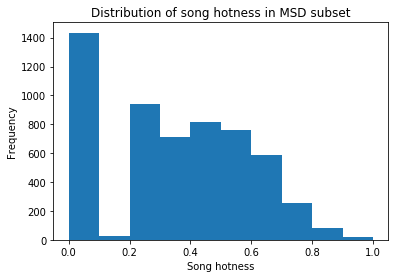

In [26]:
plt.hist(data.song_hotttnesss)
plt.title('Distribution of song hotness in MSD subset')
plt.xlabel('Song hotness')
plt.ylabel('Frequency');

In [27]:
# What percentage are zero?
print('Percentage of remaining records with zero song hotness values: {}%'.format(np.around((data['song_hotttnesss'] == 0).sum() / len(data)*100), 2))
      

Percentage of remaining records with zero song hotness values: 25.0%


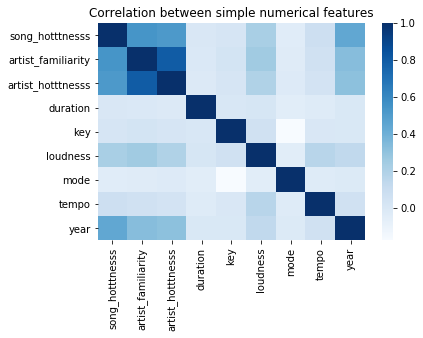

In [28]:
correlations = data.corr()
sns.heatmap(correlations, cmap = 'Blues')
plt.title('Correlation between simple numerical features');

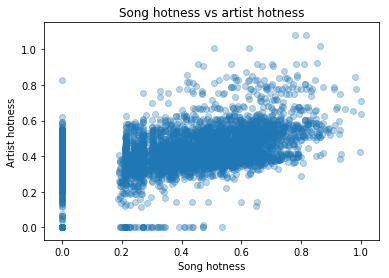

In [29]:
plt.scatter(data['song_hotttnesss'], data['artist_hotttnesss'], alpha = 0.3)
plt.title('Song hotness vs artist hotness')
plt.xlabel('Song hotness')
plt.ylabel('Artist hotness');

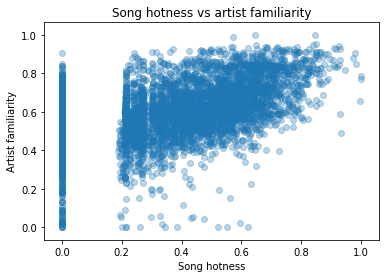

In [30]:
plt.scatter(data['song_hotttnesss'], data['artist_familiarity'], alpha = 0.3)
plt.title('Song hotness vs artist familiarity')
plt.xlabel('Song hotness')
plt.ylabel('Artist familiarity');

There is a slight positive trend of song hotness over time, which makes sense given the way that the metric is measured. We must also consider that musical tastes change over time. 

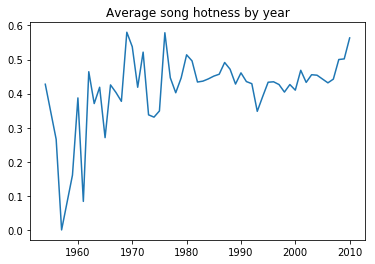

In [31]:
year_plot = data[data['year'] != 0].groupby(['year']).mean().reset_index()
plt.plot(year_plot['year'], year_plot['song_hotttnesss']);
plt.title('Average song hotness by year');

In [32]:
# Check number of years with value 0
print('Number of records with year recorded as zero: {}'.format(sum(data['year'] == 0)))

Number of records with year recorded as zero: 2584


# Merge with other datasets

The basic MSD dataset has some useful fields, but we have to explore whether we can augment this with other information. 

## Genre information

I had a look at whether we can augment the dataset with genre information. Although there is some genre information in the tags, this is mixed with other data like location and it isn't clear which is the main genre. Therefore I have linked with another dataset from Vienna University, available at: http://www.ifs.tuwien.ac.at/mir/msd/download.html


In [33]:
# Read genre info from the website
genres = pd.read_csv('http://www.ifs.tuwien.ac.at/mir/msd/partitions/msd-MAGD-genreAssignment.cls',
                       sep = '\t', 
                       header = None)

genres.columns=['track_id', 'genre_id']
genres.head()

,track_id,genre_id
0,TRAAAAK128F9318786,Pop_Rock
1,TRAAAAV128F421A322,Pop_Rock
2,TRAAAAW128F429D538,Rap
3,TRAAABD128F429CF47,Pop_Rock
4,TRAAACV128F423E09E,Pop_Rock


In [36]:
# Read genre info from the website
styles = pd.read_csv('http://www.ifs.tuwien.ac.at/mir/msd/partitions/msd-MASD-styleAssignment.cls',
                       sep = '\t', 
                       header = None)

styles.columns=['track_id', 'style']
styles.head()

,track_id,style
0,TRAAAAK128F9318786,Metal_Alternative
1,TRAAAAV128F421A322,Punk
2,TRAAAAW128F429D538,Hip_Hop_Rap
3,TRAAACV128F423E09E,Rock_Neo_Psychedelia
4,TRAAAEF128F4273421,Pop_Indie


In [37]:
# Merge on track ID
subset_augmented = subset_full.merge(genres, 
                                     how = 'left',
                                     on = 'track_id')
subset_augmented = subset_augmented.merge(styles, 
                                     how = 'left',
                                     on = 'track_id')

In [38]:
# Boo... more than half are missing - we will have to see if there are other sources that might improve things
subset_augmented['genre_id'].isna().sum(), subset_augmented['style'].isna().sum() 


(5989, 7224)

## Rhythm Histogram data. 

Copy at https://drive.google.com/open?id=1dNTS0CL5zNy17fOjdusemsiPpnMSuWPp

In [30]:
# rh_data = pd.read_csv(cur_dir + '/../../data/msd-rh.csv.gz', header=None, compression='gzip', escapechar='\'')
rh_data = pd.read_csv('../../../MSD_data/msd-rh.csv.gz', header=None, compression='gzip', escapechar='\'')



In [31]:
rh_data[60]=rh_data[60].str.replace(',','')

In [32]:
rh_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,7.224382,6.109045,6.685568,4.966105,7.842882,2.844719,3.361026,3.442607,2.590563,2.510110,3.489836,2.620875,2.981837,2.658234,1.991701,2.865213,2.446870,2.362090,2.119853,3.402324,3.312368,5.171416,4.306777,2.578843,2.354629,2.439796,2.315009,2.478483,1.720365,1.946930,2.176049,2.151473,1.484158,2.463190,1.587826,1.725714,1.896247,2.057304,1.676314,1.668819,2.377014,2.578647,2.352990,2.619982,7.261864,3.851958,2.034727,1.937198,2.327277,1.400687,1.881342,1.644958,1.651929,1.744542,1.560066,1.471327,1.278020,1.450461,1.744244,1.308790,TRUNNPU128F42509AF
1,14.677012,11.396501,6.471495,6.448495,5.532688,5.459681,4.962178,6.169852,4.361400,4.689114,5.028985,3.808006,3.670783,4.345497,3.470329,3.411302,3.164273,3.066168,2.413340,2.574592,3.005441,2.862182,2.974478,2.755254,2.206445,3.645482,2.236688,3.027635,1.394029,1.890757,1.722798,1.887297,1.530212,1.747953,1.625365,1.359184,1.404816,1.890264,1.235513,1.915746,1.394843,1.474570,1.152636,1.045539,1.150380,1.287604,1.181704,1.323699,1.039293,1.022161,1.062748,1.169235,1.154576,1.056674,0.885865,1.031910,1.069888,0.799239,0.932625,0.920351,TRHOCGC128F4289D7E
2,4.693787,8.161283,4.093479,3.973085,2.508202,2.896735,3.671773,3.639837,2.537774,2.026490,3.067868,2.307508,2.197447,1.665187,6.908271,1.751675,1.326321,1.868806,3.519019,3.226108,2.620849,2.199655,2.716995,1.371609,1.223698,1.662284,2.132717,2.728259,1.563425,10.511957,1.622031,1.747682,1.566627,1.682926,1.433441,1.676330,2.582308,2.296095,1.263071,2.048495,2.075836,1.391475,1.282799,1.161428,5.115295,1.494706,1.646880,1.675094,2.403007,1.378582,2.226650,1.726906,2.274374,1.447875,1.258306,2.076403,1.436256,1.768820,1.088751,5.942637,TRUCDEN128F422F002
3,5.732590,4.595852,4.447026,3.445079,4.157514,3.177737,2.750734,2.316945,2.617048,4.041836,2.595810,2.025904,2.128921,1.868697,1.952426,1.938566,1.718140,1.925044,1.865080,1.869095,1.321608,1.114444,1.108346,1.160560,1.051970,1.033919,1.101187,1.131778,0.973218,1.187626,1.123574,1.042106,0.910357,0.838702,0.685756,0.794708,0.728102,0.646424,1.001201,0.841439,0.633582,0.625806,0.611139,0.695433,0.613495,0.601609,0.581338,0.566299,0.587599,0.512447,0.428625,0.545786,0.512769,0.497109,0.428288,0.464276,0.434104,0.469024,0.454484,0.373569,TRIRBZT128F4248E8E
4,6.782964,4.592204,4.587584,4.003001,2.943357,2.935050,2.497146,2.544335,2.608646,2.228174,2.053194,1.925623,1.829839,2.356808,2.334097,1.979131,2.007416,1.722231,1.474112,1.762297,1.552419,1.745466,3.290660,1.363205,1.413405,1.346467,1.226538,1.289772,1.691532,1.255177,1.459558,1.268531,1.188750,1.616032,1.097459,0.902051,1.417650,1.069397,1.103072,1.104875,1.048233,0.985500,1.136311,0.849429,0.992081,1.692612,1.002904,0.721470,1.133159,0.881244,1.429873,0.927437,1.044928,0.883083,0.772829,0.828493,0.946112,0.790503,0.777186,0.999154,TRURGGS12903CC654D


In [33]:
rh_data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
count,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000
mean,10.747208,8.804710,7.545514,6.632828,6.130460,5.867655,5.436778,5.082182,5.028319,4.804715,4.618021,4.740827,4.748943,4.393691,4.123987,4.007699,3.873104,3.840052,3.802111,3.541086,3.396043,3.327304,3.236329,3.286237,3.394515,3.193727,3.020321,2.932759,2.786210,2.718177,2.688330,2.645896,2.566184,2.543914,2.508047,2.480911,2.461847,2.444112,2.327892,2.273370,2.198871,2.154295,2.106203,2.074629,2.028703,1.987840,2.001718,2.005123,2.019334,2.081961,2.033919,1.935411,1.858131,1.831933,1.807096,1.770416,1.726511,1.675519,1.657650,1.628000
std,4.745723,3.623742,2.990341,2.773978,2.634145,2.449711,2.267750,2.201609,2.311368,2.184540,2.078767,2.317916,2.554379,2.228124,2.005171,1.984086,1.998282,2.080600,2.131224,1.896828,1.773172,1.753022,1.738909,1.917375,2.334429,2.022861,1.778731,1.738296,1.561588,1.510218,1.483446,1.523024,1.447878,1.484905,1.462194,1.490071,1.487507,1.515765,1.371641,1.329778,1.212377,1.191753,1.148849,1.119682,1.068259,1.067603,1.109623,1.192496,1.327821,1.613612,1.532467,1.239517,1.108285,1.108109,1.113279,1.033209,0.968262,0.903420,0.856319,0.798481
min,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000222,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223
25%,7.434689,6.276521,5.462106,4.695081,4.304360,4.188430,3.869108,3.559366,3.461473,3.320068,3.200542,3.203318,3.127618,2.949085,2.804547,2.712347,2.593171,2.529792,2.472563,2.349306,2.271521,2.222684,2.152268,2.132991,2.095954,2.031689,1.972940,1.919386,1.850632,1.811181,1.791342,1.747137,1.710075,1.688737,1.660016,1.626730,1.606363,1.582164,1.533429,1.506323,1.477017,1.443220,1.418543,1.402386,1.377259,1.349058,1.346721,1.331677,1.318168,1.303640,1.279702,1.264551,1.240451,1.221177,1.199138,1.183471,1.163148,1.138751,1.129876,1.118636
50%,10.114451,8.432142,7.242066,6.364112,5.840643,5.617054,5.205885,4.847803,4.721892,4.527791,4.363730,4.386599,4.293448,4.031709,3.830349,3.704218,3.548375,3.468533,3.403843,3.216387,3.104187,3.035678,2.938959,2.920724,2.884994,2.783797,2.692683,2.611853,2.519052,2.460497,2.433397,2.375835,2.317170,2.283945,2.252322,2.210325,2.184457,2.156495,2.085823,2.047876,2.008082,1.967232,1.932481,1.908927,1.875202,1.836798,1.835027,1.819052,1.805077,1.792123,1.757127,1.737075,1.700535,1.676012,1.644394,1.623440,1.598302,1.562451,1.549573,1.531355
75%,13.363227,10.913700,9.300042,8.262290,7.607399,7.238793,6.734788,6.318180,6.207196,5.941693,5.721525,5.829992,5.772175,5.368905,5.071119,4.915226,4.722922,4.654492,4.593721,4.298268,4.132630,4.040328,3.914323,3.927644,3.931337,3.759103,3.599590,3.482811,3.

# Investigate numerical arrays

Several of the columns include lists of numbers, which are explored further in this section. 

The dataset contains numerical information in the form of arrays for distinct parts of each song:

1. __Bars__:  A bar (or measure) is a segment of time defined as a given number of beats. 

2. __Beats__:  A beat is the basic time unit of a piece of music; for example, each tick of a metronome. Beats are typically multiples of tatums.

3. __Sections__: Sections are defined by large variations in rhythm or timbre, e.g. chorus, verse, bridge, guitar solo, etc.

4. __Segments__: A set of sound entities (typically under a second) each relatively uniform in timbre and harmony. 

5. __Tatums__: Tatums represent the lowest regular pulse train that a listener intuitively infers from the timing of perceived musical events (segments). 

All of these parts have two columns associated with them:

* __Start:__ the markers explained above, in seconds.

* __Confidence:__ Confidence indicates the reliability of its corresponding attribute. Elements carrying a small confidence value should be considered speculative. 

The most detailed information is for segments, which contain several other features:
* __Loudness_max__: peak loudness value within the segment
* __Loudness_max_time__: offset within the segment of the point of maximum loudness 
* __Loudness_start__: loudness level at the start of the segment 
* __Pitches__:  is given by a “chroma” vector, corresponding to the 12 pitch classes C, C#, D to B, with values ranging from 0 to 1 that describe the relative dominance of every pitch in the chromatic scale.
* __Timbre__: is the quality ('colour') of a musical note. It is what makes a particular musical sound different from another, even when they have the same pitch and loudness. The dataset represents timbre as a 12 dimensional vector of 'MFCC-like' features, each of which are unbounded values roughly centered around 0. 

The number of segments per track is variable and each segment can itself be of variable length - typically they seem to be around 0.2 - 0.4 seconds but can be as long as 10 seconds or more.

In [106]:
# Identify the columns that have arrays
numerical_array_list = ['bars_confidence',
                       'bars_start',
                       'beats_confidence',
                       'beats_start',
                        'sections_confidence',
                        'sections_start',
                        'segments_confidence',
                        'segments_loudness_max',
                        'segments_loudness_max_time',
                        'segments_loudness_start',
                        'segments_pitches',
                        'segments_start',
                        'segments_timbre',
                        'tatums_confidence',
                        'tatums_start'
                       ]

# Create lookups
lookups = dict(enumerate(numerical_array_list))

# Get the lengths of each array
array_lengths = []
for column in numerical_array_list:
    length = [len(i) for i in subset_full[column]]
    array_lengths.append(length) 


It is already clear from the descriptions, and verified by looking at the shapes of the arrays for the first few tracks below, that they will be of different lengths. This is because the length of tracks and frequency of the audio features varies greatly.  

Below, we can see that the histogram of the length of the arrays for the different events is highly skewed. 

In [83]:
# Let's look at the shape of the arrays for the first songs
print('Array shapes for the first song')
for i, column in enumerate(numerical_array_list):
    print(i, subset_full[column][0].shape) 

print('Array shapes for the second song')
for i, column in enumerate(numerical_array_list):
    print(i, subset_full[column][1].shape) 

Array shapes for the first song
0 (73,)
1 (73,)
2 (294,)
3 (294,)
4 (6,)
5 (6,)
6 (562,)
7 (562,)
8 (562,)
9 (562,)
10 (562, 12)
11 (562,)
12 (562, 12)
13 (587,)
14 (587,)
Array shapes for the second song
0 (69,)
1 (69,)
2 (333,)
3 (333,)
4 (9,)
5 (9,)
6 (774,)
7 (774,)
8 (774,)
9 (774,)
10 (774, 12)
11 (774,)
12 (774, 12)
13 (997,)
14 (997,)


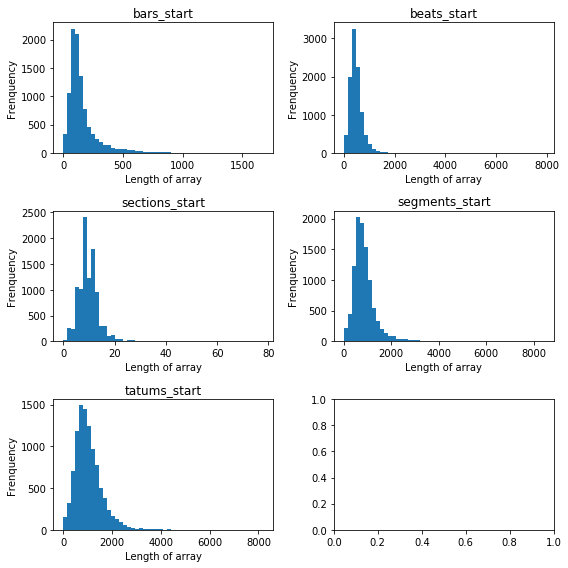

In [191]:
# Select the "start" variable of each type
start_list = [1, 3, 5, 11, 14]

fig, axes = plt.subplots(3, 2, figsize = (8, 8))
ax = axes.ravel()
for i, k in enumerate(start_list):
    ax[i].hist(array_lengths[k], bins = 50)
    ax[i].set_title(lookups[k])
    ax[i].set_xlabel('Length of array')
    ax[i].set_ylabel('Frenquency')
plt.tight_layout()

The segment pitches and timbre information comes in 12 vectors. 

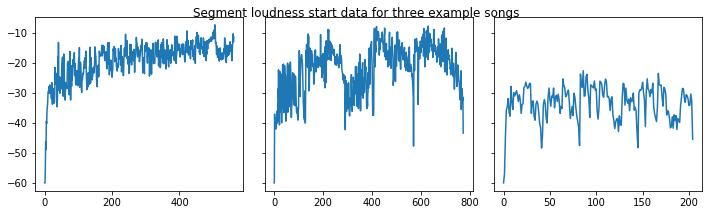

In [197]:

fig, axes = plt.subplots(1, 3, figsize = (10, 3), sharey = True)
ax = axes.ravel()
for i in range(3):
    ax[i].plot(subset_full['segments_loudness_start'][i])
plt.suptitle('Segment loudness start data for three example songs')
plt.tight_layout()

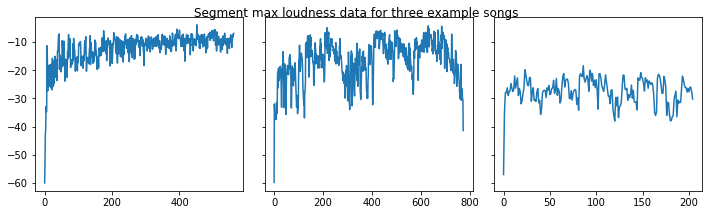

In [198]:
fig, axes = plt.subplots(1, 3, figsize = (10, 3), sharey = True)
ax = axes.ravel()
for i in range(3):
    ax[i].plot(subset_full['segments_loudness_max'][i])
plt.suptitle('Segment max loudness data for three example songs')
plt.tight_layout()

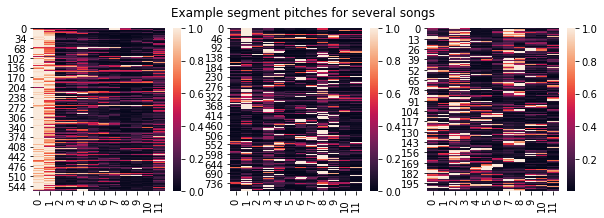

In [157]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3))
sns.heatmap(subset_full['segments_pitches'][0], ax = ax1)
sns.heatmap(subset_full['segments_pitches'][1], ax = ax2)
sns.heatmap(subset_full['segments_pitches'][2], ax = ax3)
plt.suptitle('Segment pitches for three example songs');



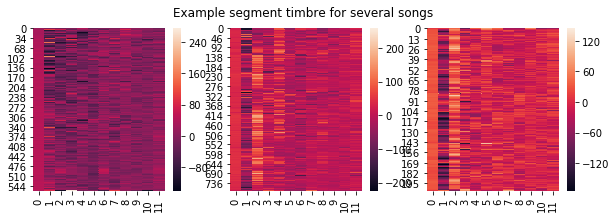

In [158]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3))
sns.heatmap(subset_full['segments_timbre'][0], ax = ax1)
sns.heatmap(subset_full['segments_timbre'][1], ax = ax2)
sns.heatmap(subset_full['segments_timbre'][2], ax = ax3)
plt.suptitle('Segment timbre for three example songs');

Simple feature engineering to incoporate these variables would involve reducing them down to fit with the rest of the simple numerical data in a 2D array. Without being experts in sound analysis, it is difficult to know what aspects are likely to be useful or important. From a review of the literature, it seems there are several options:

* Discard the features: This seems unsatisfactory until they have been tested in some models to see if they are predictive
* Use the mean and median of the arrays: This captures the main information although loses all of the time dimension
* Include mean, variance and quartiles of the data: This makes it possible to include some simple information about how the track varies over time. 
* Try to use the arrays as they are provided, in which case the segment data provides the most detailed information and seems to be the most promising option.


# Possible next steps

We are considering a number of possible next steps.

__1. Explore the segment data (i.e. all the columns that include data as arrays such as segments_loudness_max, segments_pitches, segments_timbre).__ 
* See how we can represent and use these arrays (see above). 
* Confidence of each measure should probably not be represented separately (maybe multiply it by the measure).

__2. Explore and clean categorical variables (e.g. how to use the data on similar artists, artist_terms).__ 
* Given the strong link between artist hotness and song hotness, these similarity metrics could be promising to explore. 

__3. Since we have so much missing song hotness information, we may need to extract extra records from the full dataset.__
* This may or may not be useful, depending on what we find following deeper exploration of the subset. 
* It would also be good to see if we can get the danceability and energy variables back from the main dataset, since these are missing from the subset (it may be due to the Echo Nest API closing). 
* Alternatively, some of the papers use different popularity metrics (such as play counts) and we could try usisng those 